In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/toy_8-modes')
sys.path.append('/content/gdrive/My Drive/FrEIA')
sys.path.append('/content/gdrive/My Drive/FrEIA/modules')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%matplotlib notebook
from time import time

import torch
import torch.nn as nn
import torch.optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from framework import InputNode, OutputNode, Node, ReversibleGraphNet
from modules import GLOWCouplingBlock, PermuteRandom

import pickle
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

%matplotlib inline

cuda


## Setting up the data

We load the generated data by sampling $x_1, x_2, x_3, x_4$ from a Gaussian distribution. The dataset will contain $10^{6}$ samples,and $10$ more we will use for testing purposes.

You can see a plot of the test data below.

In the forward process our model is supposed to predict the final position of the kinematic arm. It is calculated with open formulas $y_1 = x_1+l_1 sin(x_2) +l_2 sin(x_3-x_2)+l_3 sin(x_4-x_3-x_2), y_2 = l_1 cos(x_2) +l_2 cos(x_3-x_2)+l_3 cos(x_4-x_3-x_2)$. In the reverse direction the model returns us possible x-s that can bring us to these y-s.

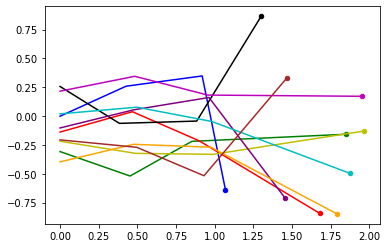

In [3]:
test_split = 10

pos = pickle.load(open('/content/gdrive/My Drive/toy_8-modes/X_tensor', 'rb'))
labels = pickle.load(open('/content/gdrive/My Drive/toy_8-modes/Y_tensor', 'rb'))
l1, l2, l3 = 0.5, 0.5, 1.
color={0:'g', 1:'b', 2:'r', 3:'y', 4:'k', 5:'purple', 6:'c', 7:'m', 8:'orange', 9:'brown'} 
for i in range(test_split):
    x1, x2, x3, x4 = pos[i]
    y1, y2 = labels[i]
    plt.plot([0, l1*np.cos(x2), l1*np.cos(x2)+l2*np.cos(x3-x2), l1*np.cos(x2)+l2*np.cos(x3-x2)+l3*np.cos(x4-x3-x2)], 
             [x1, x1+l1*np.sin(x2),x1+l1*np.sin(x2)+l2*np.sin(x3-x2), x1+l1*np.sin(x2)+l2*np.sin(x3-x2)+l3*np.sin(x4-x3-x2)],
             c=color[i])
    plt.scatter(y1,y2,c=color[i], s=20)
plt.show()

In [4]:
ndim_tot = 4
ndim_x = 4
ndim_y = 2
ndim_z = 2


hidden_layer_sizes = 128


def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, hidden_layer_sizes), nn.ReLU(),
                         nn.Linear(hidden_layer_sizes, hidden_layer_sizes), nn.ReLU(),
                         nn.Linear(hidden_layer_sizes,  c_out))

nodes = [InputNode(ndim_tot, name='input')]

for k in range(6):
    nodes.append(Node(nodes[-1],
                      GLOWCouplingBlock,
                      {'subnet_constructor':subnet_fc, 'clamp':8.0},
                      name=F'coupling_{k}'))
    nodes.append(Node(nodes[-1],
                      PermuteRandom,
                      {'seed':k},
                      name=F'permute_{k}'))

nodes.append(OutputNode(nodes[-1], name='output'))

model = ReversibleGraphNet(nodes, verbose=False)

In [5]:
# Training parameters
n_epochs = 160
n_its_per_epoch = 200
batch_size = 500

lr = 1e-4
l2_reg = 1e-6

y_noise_scale = 5e-2
zeros_noise_scale = 2e-2

# relative weighting of losses:
lambd_predict = 200
lambd_latent = 50
lambd_rev = 50

pad_x = torch.zeros(batch_size, ndim_tot - ndim_x)
pad_yz = torch.zeros(batch_size, ndim_tot - ndim_y - ndim_z)

trainable_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_parameters, lr=lr, betas=(0.8, 0.9),
                             eps=1e-6, weight_decay=l2_reg)


def MMD_multiscale(x, y):
    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    dxx = rx.t() + rx - 2.*xx
    dyy = ry.t() + ry - 2.*yy
    dxy = rx.t() + ry - 2.*zz

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

                 
    mmd_back_kernels =  [(0.6, 0.1), (4.8, 0.5), (1.2, 2)]
    for C,a in mmd_back_kernels:
        XX += C**a * ((C + dxx) / a)**-a
        YY += C**a * ((C + dyy) / a)**-a
        XY += C**a * ((C + dxy) / a)**-a
    return torch.mean(XX + YY - 2.*XY) #


def fit(input, target):
    return torch.mean((input - target)**2)

loss_backward = MMD_multiscale
loss_latent = MMD_multiscale
loss_fit = fit

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(pos[:test_split], labels[:test_split]),
    batch_size=10, shuffle=True, drop_last=True)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(pos[test_split:], labels[test_split:]),
    batch_size=batch_size, shuffle=True, drop_last=True)

In [6]:


def train(i_epoch=0):
    model.train()

    l_tot = 0
    batch_idx = 0
    
    t_start = time()
    
    # If MMD on x-space is present from the start, the model can get stuck.
    # Instead, ramp it up exponetially.  
    loss_factor = min(1., 2. * 0.002**(1. - (float(i_epoch) / n_epochs)))
    loss_list_all = []
    loss_list_y = []
    for x, y in train_loader:
        batch_idx += 1
        if batch_idx > n_its_per_epoch:
            break

        x, y = x.to(device), y.to(device)
        
        y_clean = y.clone()
        pad_x = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                ndim_x, device=device)
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)

        y += y_noise_scale * torch.randn(batch_size, ndim_y, dtype=torch.float, device=device) #add noise

        x, y = (torch.cat((x, pad_x),  dim=1),
                torch.cat((torch.randn(batch_size, ndim_z, device=device), pad_yz, y),
                          dim=1))
        

        optimizer.zero_grad()

        # Forward step:

        output = model(x)

        # Shorten output, and remove gradients wrt y, for latent loss
        y_short = torch.cat((y[:, :ndim_z], y[:, -ndim_y:]), dim=1)

        l = lambd_predict * loss_fit(output[:, ndim_z:], y[:, ndim_z:]) #y_loss

        output_block_grad = torch.cat((output[:, :ndim_z],
                                       output[:, -ndim_y:].data), dim=1)

        loss_list_y.append(l)

        l += lambd_latent * loss_latent(output_block_grad, y_short) #forward loss
        l_tot += l.data.item() 

        l.backward()

        # Backward step:
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)
        y = y_clean + y_noise_scale * torch.randn(batch_size, ndim_y, device=device)

        orig_z_perturbed = (output.data[:, :ndim_z] + y_noise_scale *
                            torch.randn(batch_size, ndim_z, device=device))
        y_rev = torch.cat((orig_z_perturbed, pad_yz,
                           y), dim=1)
        y_rev_rand = torch.cat((torch.randn(batch_size, ndim_z, device=device), pad_yz,
                                y), dim=1)
        
        output_rev = model(y_rev, rev=True)
        output_rev_rand = model(y_rev_rand, rev=True)

        l_rev = (
            lambd_rev
            * loss_factor
            * loss_backward(output_rev_rand[:, :ndim_x],
                            x[:, :ndim_x])
        )

        l_rev += lambd_predict * loss_fit(output_rev, x)
        
        l_tot += l_rev.data.item()
        l_rev.backward()

        for p in model.parameters():
            p.grad.data.clamp_(-8.00, 8.00)

        optimizer.step()
             
        loss_list_all.append(l_tot)
    train_loss_all.append(loss_list_all[-1])
    train_loss_y.append(loss_list_y[-1])

    return l_tot / batch_idx

In [ ]:
for param in trainable_parameters:
    param.data = 0.05*torch.randn_like(param)           
model.to(device)

N_samp = 10

for i in test_loader:
  x_samps, y_samps = i

y_samps_0 = torch.cat([torch.randn(10, ndim_z),
                     zeros_noise_scale * torch.zeros((10), ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
       

train_loss_all = []
train_loss_y = []


t_start = time()
for i_epoch in tqdm(range(n_epochs)):
  
    train(i_epoch)

    pickle.dump(model, open('/content/gdrive/My Drive/toy_8-modes/model2/model2', 'wb'))
    
    model.eval()
    rev_x = model(y_samps_0.to(device), rev=True)
    y_pred = model(x_samps.to(device))

    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    axes[0].axis([-0.1,2,-1.3,1.3])
    axes[0].set_title('Predicted y-s (Forwards Process)')        
    for i in range(N_samp):
      x1, x2, x3, x4 = x_samps[i].cpu().data.numpy()
      _, _, y1, y2 = y_pred[i].cpu().data.numpy()
      axes[0].plot([0, l1*np.cos(x2), l1*np.cos(x2)+l2*np.cos(x3-x2), l1*np.cos(x2)+l2*np.cos(x3-x2)+l3*np.cos(x4-x3-x2)], [x1, x1+l1*np.sin(x2),x1+l1*np.sin(x2)+l2*np.sin(x3-x2), x1+l1*np.sin(x2)+l2*np.sin(x3-x2)+l3*np.sin(x4-x3-x2)], c=color[i])
      axes[0].plot(y1, y2, 'o', c=color[i])  

    axes[1].axis([-0.1,2,-1.3,1.3])
    axes[1].set_title('Generated x-s (Backwards Process)')
    for i in range(N_samp):
      x1, x2, x3, x4 = rev_x[i].cpu().data.numpy()
      _, _, y1, y2 = y_samps_0[i].cpu().data.numpy()
      axes[1].plot(y1, y2, 'o', c=color[i])     
      axes[1].plot([0, l1*np.cos(x2), l1*np.cos(x2)+l2*np.cos(x3-x2), l1*np.cos(x2)+l2*np.cos(x3-x2)+l3*np.cos(x4-x3-x2)], [x1, x1+l1*np.sin(x2),x1+l1*np.sin(x2)+l2*np.sin(x3-x2), x1+l1*np.sin(x2)+l2*np.sin(x3-x2)+l3*np.sin(x4-x3-x2)], c=color[i])
    fig.savefig('/content/gdrive/My Drive/toy_8-modes/model2/eval/'+str(i_epoch))
    # fig.show()

    fig = plt.subplots(figsize=(10,10))
    for j in range(100):
        y_samps_ = torch.cat([torch.randn(10, ndim_z),
                        zeros_noise_scale * torch.zeros((10), ndim_tot - ndim_y - ndim_z), 
                        y_samps], dim=1).to(device) 
        rev_x = model(y_samps_, rev=True)
        for i in range(9):
          plt.subplot(3,3,i+1)
          x1, x2, x3, x4 = rev_x[i].cpu().data.numpy()
          _, _, y1, y2 = y_samps_[i].cpu().data.numpy()
          plt.axis([-0.1,2,-1.3,1.3])
          plt.plot([0, l1*np.cos(x2), l1*np.cos(x2)+l2*np.cos(x3-x2), l1*np.cos(x2)+l2*np.cos(x3-x2)+l3*np.cos(x4-x3-x2)], [x1, x1+l1*np.sin(x2),x1+l1*np.sin(x2)+l2*np.sin(x3-x2), x1+l1*np.sin(x2)+l2*np.sin(x3-x2)+l3*np.sin(x4-x3-x2)], c=color[i], alpha=0.1)
          plt.plot(y1, y2, 'o', c=color[i])
    plt.savefig('/content/gdrive/My Drive/toy_8-modes/model2/generation/generation_'+str(i_epoch))
    if i_epoch<5:
        plt.figure(figsize=(10,5))
        plt.plot(range(len(train_loss_all)), train_loss_all, label='all')
        plt.plot(range(len(train_loss_y)), train_loss_y, label='y')
        plt.legend()
        plt.savefig('/content/gdrive/My Drive/toy_8-modes/model2/losses/train_loss_'+str(i_epoch))
    else:
        plt.figure(figsize=(10,5))
        plt.plot(range(len(train_loss_all)-5, len(train_loss_all)), train_loss_all[-5:], label='all')
        plt.plot(range(len(train_loss_y)-5, len(train_loss_y)), train_loss_y[-5:], label='y')
        plt.legend()
        plt.savefig('/content/gdrive/My Drive/toy_8-modes/model2/losses/train_loss_'+str(i_epoch))

print(f"\n\nTraining took {(time()-t_start)/60:.2f} minutes\n")

  4%|▍         | 7/160 [01:34<34:23, 13.48s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 31%|███       | 49/160 [11:10<24:57, 13.49s/it]

In [ ]:
train_loss

In [ ]:
pickle.dump(model, open('/content/gdrive/My Drive/toy_8-modes/model2/model2', 'wb'))

In [ ]:
model=pickle.load(open('/content/gdrive/My Drive/toy_8-modes/model2/model2', 'rb'))
model.eval()

In [ ]:
fig = plt.subplots(figsize=(10,10))

for i in test_loader:
  x_samps, y_samps = i

for j in range(100):
    y_samps_ = torch.cat([torch.randn(10, ndim_z),
                     zeros_noise_scale * torch.zeros((10), ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1).to(device) 
    rev_x = model(y_samps_, rev=True)
    for i in range(9):
      plt.subplot(3,3,i+1)
      x1, x2, x3, x4 = rev_x[i].cpu().data.numpy()
      _, _, y1, y2 = y_samps_[i].cpu().data.numpy()
      plt.axis([-0.1,2,-1.3,1.3])
      plt.plot([0, l1*np.cos(x2), l1*np.cos(x2)+l2*np.cos(x3-x2), l1*np.cos(x2)+l2*np.cos(x3-x2)+l3*np.cos(x4-x3-x2)], [x1, x1+l1*np.sin(x2),x1+l1*np.sin(x2)+l2*np.sin(x3-x2), x1+l1*np.sin(x2)+l2*np.sin(x3-x2)+l3*np.sin(x4-x3-x2)], c=color[i], alpha=0.5)
      plt.plot(y1, y2, 'o', c=color[i])
plt.savefig('/content/gdrive/My Drive/toy_8-modes/model2/final_generation')
plt.show()

In [ ]:
model(pos[:10].to(device))

In [ ]:
pos[:10]